# 微调

在早先的一些章节中，我们介绍了如何在只有 6 万张图像的 Fashion-MNIST 训练数据集上训练模型。我们还描述了学术界当下使用最广泛的大规模图像数据集 ImageNet，它有超过一千万的图像和一千类的物体。然而，我们平常接触到数据集的规模通常在这两者之间。

假设我们想从图像中识别出不同种类的椅子，然后将购买链接推荐给用户。一个可能的方法是先找出一百种常见的椅子，为每种椅子拍摄一千张不同角度的图像；然后在收集到的图像数据集上训练一个分类模型。这个数据集虽然可能比 Fashion-MNIST 要庞大，但样本数仍然不及 ImageNet 样本数的十分之一。这可能会导致适用于 ImageNet 的复杂模型在这个数据集上过拟合。同时，因为数据量有限，最终训练得到的模型的精度也可能达不到实用的要求。

为了应对上述问题，一个显而易见的解决办法是收集更多的数据。然而，收集和标注数据会花费大量的时间和资金。例如，为了收集 ImageNet 数据集，研究人员花费了数百万美元的研究经费。虽然目前的数据采集成本已降低了不少，但其成本仍然不可忽略。

另外一种解决办法是应用迁移学习（transfer learning），将从源数据集学到的知识迁移到目标数据集上。例如，虽然 ImageNet 的图像大多跟椅子无关，但在该数据集上训练的模型可以抽取较通用图像特征，从而能够帮助识别边缘、纹理、形状和物体组成等。这些类似的特征对于识别椅子也可能同样有效。

本小节我们介绍迁移学习中的一个常用技术：微调。如图 9.1 所示，微调由以下四步构成：

1. 在源数据集（例如 ImageNet 数据集）上预训练一个神经网络模型，即源模型。
2. 创建一个新的神经网络模型，即目标模型。它复制了源模型上除了输出层外的所有模型设计及其参数。我们假设这些模型参数包含了源数据集上学习到的知识，且这些知识同样适用于目标数据集。我们还假设源模型的输出层跟源数据集的标签紧密相关，因此在目标模型中不予采用。
3. 为目标模型添加一个输出大小为目标数据集类别个数的输出层，并随机初始化该层的模型参数。
4. 在目标数据集（例如椅子数据集）上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的。

![微调。](../img/finetune.svg)


## 热狗识别

接下来我们来实践一个具体的例子：热狗识别。我们将基于一个小数据集对在 ImageNet 数据集上训练好的 ResNet 模型进行微调。该小数据集含有数千张包含热狗和不包含热狗的图像。我们将使用微调得到的模型来识别一张图像中是否包含热狗。

首先，导入实验所需的包或模块。Gluon 的`model_zoo`包提供了常用的预训练模型。如果你希望获取更多的计算机视觉的预训练模型，可以使用 GluonCV 工具包 [1]。

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import gluonbook as gb
from mxnet import gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo
from mxnet.gluon import utils as gutils
import os
import zipfile

### 获取数据集

我们使用的热狗数据集是从网上抓取的，它含有 1400 张包含热狗的正例图像，和同样多包含其他食品的负例图像。各类的 1000 张图像被用作训练，其余则用于测试。

我们首先将压缩后的数据集下载到路径`../data`之下。然后在该路径将下载好的数据集解压，得到两个文件夹`hotdog/train`和`hotdog/test`。这两个文件夹下面均有`hotdog`和`not-hotdog`两个类别文件夹，每个类别文件夹里面是对应的图像文件。

In [2]:
data_dir = '../data'
base_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/'
fname = gutils.download(
    base_url + 'gluon/dataset/hotdog.zip',
    path=data_dir, sha1_hash='fba480ffa8aa7e0febbb511d181409f899b9baa5')
with zipfile.ZipFile(fname, 'r') as z:
    z.extractall(data_dir)

我们创建两个`ImageFolderDataset`实例来分别读取训练数据集和测试数据集中的所有图像文件。

In [3]:
train_imgs = gdata.vision.ImageFolderDataset(
    os.path.join(data_dir, 'hotdog/train'))
test_imgs = gdata.vision.ImageFolderDataset(
    os.path.join(data_dir, 'hotdog/test'))

下面画出前 8 张正例图像和最后 8 张负例图像。可以看到，它们的大小和高宽比各不相同。

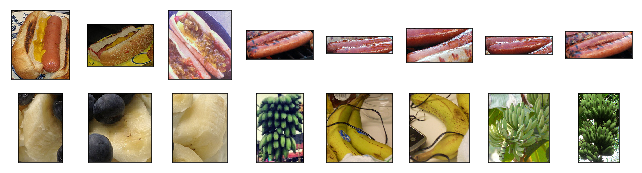

In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
gb.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

在训练时，我们先从图像中裁剪出随机大小和随机高宽比的一块随机区域，然后将该区域缩放为高和宽均为 224 像素的输入。测试时，我们将图像的高和宽均缩放为 256 像素，然后从中裁剪出高和宽均为 224 像素的中心区域作为输入。此外，我们对 RGB（红、绿、蓝）三个颜色通道的数值做标准化：每个数值减去该通道所有数值的平均值，再除以该通道所有数值的标准差作为输出。

In [5]:
# 指定 RGB 三个通道的均值和方差来将图像通道归一化。
normalize = gdata.vision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomResizedCrop(224),
    gdata.vision.transforms.RandomFlipLeftRight(),
    gdata.vision.transforms.ToTensor(),
    normalize])

test_augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.Resize(256),
    gdata.vision.transforms.CenterCrop(224),
    gdata.vision.transforms.ToTensor(),
    normalize])

### 定义和初始化模型

我们使用在 ImageNet 数据集上预训练的 ResNet-18 作为源模型。这里指定`pretrained=True`来自动下载并加载预训练的模型参数。

In [6]:
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)

预训练的源模型实例含有两个成员变量：`features`和`output`。前者包含模型除输出层以外的所有层，后者为模型的输出层。这样划分的主要目的是为了方便微调除输出层以外所有层的模型参数。下面打印源模型的成员变量`output`。作为一个全连接层，它将 ResNet 最终的全局平均池化层输出变换成 ImageNet 数据集上 1000 类的输出。

In [7]:
pretrained_net.output

Dense(512 -> 1000, linear)

我们新建一个神经网络作为目标模型。它的定义跟预训练的源模型一样，但最后的输出个数等于目标数据集的类别数。在下面的代码中，目标模型实例`finetune_net`的成员变量`features`中的模型参数被初始化为源模型相应层的模型参数。由于`features`中的模型参数是在 ImageNet 数据集上预训练得到的，已经足够好，因此一般只需使用较小的学习率来“微调”这些参数。而成员变量`output`中的模型参数采用了随机初始化，一般需要更大的学习率从头训练。假设`Trainer`实例中的学习率为 $\eta$，我们设成员变量`output`中的模型参数在迭代中使用 $10\eta$ 的学习率。

In [8]:
finetune_net = model_zoo.vision.resnet18_v2(classes=2)
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier())
# output 中的模型参数将在迭代中使用 10 倍大的学习率。
finetune_net.output.collect_params().setattr('lr_mult', 10)

### 微调模型

我们先定义一个使用微调的训练函数`train_fine_tuning`以便多次调用。

In [9]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5):
    train_iter = gdata.DataLoader(
        train_imgs.transform_first(train_augs), batch_size, shuffle=True)
    test_iter = gdata.DataLoader(
        test_imgs.transform_first(test_augs), batch_size)
    ctx = gb.try_all_gpus()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gloss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': 0.001})
    gb.train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs)

我们将`Trainer`实例中的学习率设的小一点，例如 0.01，以便微调预训练得到的模型参数。根据前面的设置，我们将以 10 倍的学习率从头训练目标模型的输出层参数。

In [10]:
train_fine_tuning(finetune_net, 0.01)

training on [gpu(0), gpu(1), gpu(2), gpu(3), gpu(4), gpu(5), gpu(6), gpu(7)]


epoch 1, loss 4.7072, train acc 0.667, test acc 0.915, time 39.8 sec


epoch 2, loss 0.5600, train acc 0.884, test acc 0.924, time 16.2 sec


epoch 3, loss 0.8565, train acc 0.859, test acc 0.922, time 13.9 sec


epoch 4, loss 0.4958, train acc 0.901, test acc 0.945, time 13.4 sec


epoch 5, loss 0.3646, train acc 0.909, test acc 0.944, time 14.7 sec


作为对比，我们定义一个相同的模型，但将它所有的模型参数都初始化为随机值。由于整个模型都需要从头训练，我们可以使用较大的学习率。

In [11]:
scratch_net = model_zoo.vision.resnet18_v2(classes=2)
scratch_net.initialize(init=init.Xavier())
train_fine_tuning(scratch_net, 0.1)

training on [gpu(0), gpu(1), gpu(2), gpu(3), gpu(4), gpu(5), gpu(6), gpu(7)]


epoch 1, loss 0.7062, train acc 0.691, test acc 0.825, time 14.6 sec


epoch 2, loss 0.4359, train acc 0.796, test acc 0.825, time 12.8 sec


epoch 3, loss 0.4233, train acc 0.798, test acc 0.833, time 11.8 sec


epoch 4, loss 0.4255, train acc 0.807, test acc 0.781, time 11.7 sec


epoch 5, loss 0.4032, train acc 0.814, test acc 0.833, time 12.7 sec


可以看到，微调的模型因为参数初始值更好，往往在相同迭代周期下取得更高的精度。


## 小结


* 迁移学习将从源数据集学到的知识迁移到目标数据集上。微调是迁移学习的一种常用技术。
* 目标模型复制了源模型上除了输出层外的所有模型设计及其参数，并基于目标数据集微调这些参数。而目标模型的输出层需要从头训练。
* 一般来说，微调参数会使用较小的学习率，而从头训练输出层可以使用较大的学习率。


## 练习

* 不断增大`finetune_net`的学习率。精度会有什么变化？
* 进一步调节对比试验中`finetune_net`和`scratch_net`的超参数。它们的精度是不是依然有区别？
* 将`finetune_net.features`中的参数固定为源模型的参数而不在训练中迭代，结果会怎样？你可能会用到以下代码。

In [12]:
finetune_net.features.collect_params().setattr('grad_req', 'null')

* 事实上`ImageNet`数据集里也有“hotdog”（“热狗”）这个类。它在输出层对应的权重参数可以用以下代码获取。我们可以怎样使用这个参数？

In [13]:
weight = pretrained_net.output.weight
hotdog_w = nd.split(weight.data(), 1000, axis=0)[713]
hotdog_w.shape

(1, 512)

## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/2272)

![](../img/qr_fine-tuning.svg)

## 参考文献

[1] GluonCV 工具包。https://gluon-cv.mxnet.io/